# Tutorial: k-core Visualizations

This tutorial explains the basic usage of the $k$-core visualizations in the paper *Deterministic Construction of Typical Networks in Network Models*. Our visualizations make use of a simple version of the the LaNet-vi algorithm of [Alvarez-Hamlin et al. (NeurIPS, 2005)](https://proceedings.neurips.cc/paper/2005/hash/b19aa25ff58940d974234b48391b9549-Abstract.html).

In [1]:
from kcoreviz import draw_kcore_viz, vertex_positions, shell_cluster_decomposition, edge_filter, linscaling

import graph_tool as gt
from graph_tool import *

import matplotlib as mpl
import matplotlib.pyplot as plt

import numpy as np

The cell below shows a basic example: A Visualization of the Karate Club network using default settings.

In [ ]:
# parameters
output_dir = './output/'       

# load the network from the Netzschleuder repository
g = gt.collection.ns["karate/77"]

# create the visualization
draw_kcore_viz(
    g,
    output=f'{output_dir}karate.svg'
)

In the following, we show a fully customized layout using all keyword arguments. We are also using a much larger network, the Cora citation network, to show the scalability of the method.

In [ ]:
# parameters
output_dir = './output/'                # where to save the output
cmap = mpl.colormaps['viridis_r']       # color map
efrac = 0.005                           # fraction of edges to visualize
ecolor = [0.847, 0.863, 0.839, 0.95]    # color for edges
vedge_color = [0.20, 0.22, 0.22, 1.0]   # vertex edge color
w0 = 0.2                                # minimal edge border width
w1 = 1.2                                # maximal edge border width
r0 = 1.0                                # minimal radial coordinate
r1 = 25.0                               # maximal radial coordinate
s0 = 5.0                                # minimal vertex size
s1 = 20.0                               # maximal vertex size
fit_view = True                         # fit the drawn elements to view
output_size = (800, 800)                # output image size
seed = 1729                             # seed for random number generators

# load the network from the Netzschleuder repository
g = gt.collection.ns['cora']

# preprocess the network
gt.generation.remove_parallel_edges(g)
gt.generation.remove_self_loops(g)

# create the visualization
draw_kcore_viz(
    g,
    cmap=cmap,  
    efrac=efrac,
    ecolor=ecolor,
    output=f'{output_dir}cora.svg'
)

To only obtain the vertex positions in Cartesian coordinates, you can use the function `vertex_positions`, as follows:

To make it easier to build on this layout using `graph_tool`'s visualization capabilities, we provide a function that allows to decompose the network into `shells`, i.e., sets of nodes with the same value of a aroperty, and `clusters`, i.e., connected components when subsetting  the network to the node-induced subgraphs of the shells. The `vertex_positions` functions uses this decomposition and aranged nodes with a radial coordinate determined by the property value (higher value closer to the center) and angular coordinates determined by the cluster (each cluster has a angular slice of size proportional to the number of nodes in it, and nodes are randomly distributed within the slice). The function `draw_kcore_viz` uses the coreness of a vertex for the composition but other property maps are also possible, e.g., degree. We are using the `edge_filter` function to only show a subset of $0.3\%$ of edges.

In [ ]:
# parameters
output_dir = './output/'  # where to save the output
eps = 0.75                # trade-off between a nodes property value and the average property value of its neighbors in determining the radial coordiante
r0 = 1.0                  # minimal radial coordinate
r1 = 10.0                 # maximal radial coordinate
s0 = 2.0                  # minimal vertex size
s1 = 10.0                 # maximal vertex size
seed = 1729               # seed for random number generators
efrac = 0.003             # fraction of edges to visualize
ecolor = 'grey'           # edge color
ewidth = 0.5              # edge pen width
vcolor = 'dodgerblue'     # vertex color
vedgewidth = 0.25         # vertex edge pen width
output_size = (800, 800)  # output image size

# initialize random number generator
rng = np.random.default_rng(seed)

# load the network
g = gt.collection.ns['cora']

# preprocess the network
gt.generation.remove_parallel_edges(g)
gt.generation.remove_self_loops(g)
g = gt.topology.extract_largest_component(g)

# compute degrees
degree = g.degree_property_map("total")

# compute the shell-cluster decomposition based on degree
shells, clusters = shell_cluster_decomposition(g, degree)

# compute the vertex positions based on this decomposition
pos = vertex_positions(g, degree, clusters, eps=eps, r0=r0, r1=r1, rng=rng)

# subset the edges
g = edge_filter(g, efrac, rng=rng)

# visualize the network using graph_tool's built-in drawing function
gt.draw.graph_draw(
    g,
    pos=pos,
    vertex_size=linscaling(g, degree, s0, s1),
    vertex_fill_color=vcolor,
    vertex_pen_width=vedgewidth,
    edge_color=ecolor,
    edge_pen_width=ewidth,
    output_size=output_size,
    output=f'{output_dir}cora_degree.svg'
);

Above we used the `linscale` function that linearly interpolates between a minimum and maximum value, using

$s_\mathrm{lin}(k) = (s_1 - s_0) \cdot \frac{k - k_\mathrm{min}}{k_\mathrm{max} - k_\mathrm{min}} + s_0$

respectively. Using the `reverse` keyword argument the order can be reversed. 

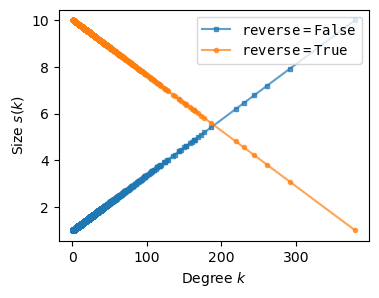

In [8]:
s0 = 1.0
s1 = 10.0

g = gt.collection.ns['cora']
degree = g.degree_property_map("total")

degree_linscaled_r = linscaling(g, degree, s0, s1, reverse=True)
degree_linscaled = linscaling(g, degree, s0, s1)
idx = np.argsort(degree.a)[::-1]

fig = plt.figure(figsize=(4, 3))
ax1 = fig.add_subplot(1, 1, 1)
ax1.plot(degree.a[idx], degree_linscaled.a[idx], label=r'$\mathtt{reverse=False}$', marker='s', markersize=3, ls='-', alpha=0.7)
ax1.plot(degree.a[idx], degree_linscaled_r.a[idx], label=r'$\mathtt{reverse=True}$', marker='o', markersize=3, ls='-', alpha=0.7)
ax1.set_xlabel(r"Degree $k$")
ax1.set_ylabel(r"Size $s(k)$")
ax1.legend();